# Airline Delayes and cancellation 

## Introduction
In this project, we would like to make airline delay predictions for the airport JFK in New York. The aim is to use relevant variables to build models for predictions of departure delay in JFK airport. We will use two datasets for the analysis. The first dataset contains information of airline delays and cancellation and the second dataset contains information of weather.

The airline delay dataset consists of more than 6 million flight observations and 28 variables of which some are technical data on airlines, airports, flight numbers, and the rest are time-related. The dataset is from the year 2010.

The weather dataset consists of hourly weather observations for "Temperature" and "Windspeed", for the year 2010.

We will explore the airline delay dataset and look at relevant variables we can use for predictions of departure delay. Then we will use the variables to build a Baysesian linear regression models and neural network models in pyro.

## Data preprocess
### Airline delay dataset
The data is loaded from a csv file into a pandas dataframe object and preprocessed. We convert the date to a datetime and set as index. We remove nan values instead of imputing values since we have lots of observations and don't need more data. We have chosen to work with a subset of the data where we investigate the first six months of 2010. The reason behind this is to reduce the amount of data but also to have data recorded from different seasons (ie. winter, spring and summer).

In [1]:
########## Imports
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

# Modelling importsfrom sklearn import linear_model
from sklearn.model_selection import train_test_split
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
# Read data
data = pd.read_csv('Data/2010.csv')

In [3]:
# Convert string to DateTime and set as index
data.FL_DATE = pd.to_datetime(data.FL_DATE, infer_datetime_format=True)
data.set_index('FL_DATE', inplace=True)
data.drop(columns='Unnamed: 27', axis=1, inplace=True) # Drop last weird column

# Drop NaN values in the variables we will use in our baseline model
data = data[data['TAXI_OUT'].notna()]
data = data[data['ORIGIN'].notna()]
data = data[data['DEST'].notna()]

# Take first 6 months
df = data.loc['2010-01-01':'2010-06-30']
# Renaming airline codes to company names
# Source: https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States

df['OP_CARRIER'].replace({
    'UA':'United Airlines',
    'AS':'Alaska Airlines',
    '9E':'Endeavor Air',
    'B6':'JetBlue Airways',
    'EV':'ExpressJet',
    'F9':'Frontier Airlines',
    'G4':'Allegiant Air',
    'HA':'Hawaiian Airlines',
    'MQ':'Envoy Air',
    'NK':'Spirit Airlines',
    'OH':'PSA Airlines',
    'OO':'SkyWest Airlines',
    'VX':'Virgin America',
    'WN':'Southwest Airlines',
    'YV':'Mesa Airline',
    'YX':'Republic Airways',
    'AA':'American Airlines',
    'DL':'Delta Airlines'
},inplace=True)

# Use only JFK
df = df[df.ORIGIN == 'JFK']

/Users/frederikhartmann/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


The two variables "DEP_TIME" and "DEP_DELAY" are time variables, and we change them both to appropriate datetime format. With this change we have exact information of flight takeoff and not just which day.

In [4]:
delays = df[['DEP_DELAY', 'DEP_TIME']]
delays['DEP_TIME'] = delays['DEP_TIME'].astype(int)

preps = []
for i in range(len(delays['DEP_TIME'])):
    # Zero fill values
    dep_time_val = str(delays['DEP_TIME'].iloc[i]).zfill(4)
    # If flight at 24:00, set that as 00:00
    if dep_time_val == str(2400):
        dep_time_act = datetime.datetime.strptime('0000','%H%M').strftime('%H:%M')
    else:
        dep_time_act = datetime.datetime.strptime(dep_time_val,'%H%M').strftime('%H:%M')
    

    # append
    preps.append(dep_time_act)

# Drop and add corrected times
df.drop(columns=['DEP_TIME'])
df['DEP_TIME'] = preps
df['DEP_TIME'] = pd.to_datetime(df['DEP_TIME'], format='%H:%M') # Convert to datetime

# Convert FL time to column
df = df.reset_index(level=0)

/var/folders/fs/10_w6dn131d7nmw8myr18l6r0000gn/T/ipykernel_63407/2530428706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delays['DEP_TIME'] = delays['DEP_TIME'].astype(int)


In [5]:
comb_date = []
# Loop through all to combine dates and time
for i in range(len(df['DEP_TIME'])):

    # Get date and time
    date = datetime.datetime.date(df['FL_DATE'].iloc[i])
    time = datetime.datetime.time(df['DEP_TIME'].iloc[i])

    # Get combined as a string
    comb = datetime.datetime.combine(date, time).strftime('%Y-%m-%d %H:%M:%S')

    #append
    comb_date.append(comb)


In [6]:
# Add column, and remove DEP_TIME and FL_DATE
df['DATE_TIME'] = pd.to_datetime(comb_date)
# Get dep time as time only
df['DEP_TIME'] = pd.to_datetime(df['DEP_TIME'], format='%H:%M').dt.time # Convert to datetime


In [7]:
# Move it to the front of the data frame
dates = df.pop('DATE_TIME')
df.insert(0, 'DATE_TIME', dates)


### Weather dataset
The weather data is loaded and only relevant features are extracted. In the dataset we use weather observations for the first six months of 2010 as the other dataset. 

In [8]:
# Load weather data
df_weather_all = pd.read_csv('Data/Weather.csv')
# Select only relevant features
df_weather = df_weather_all[["NAME","DATE","HLY-TEMP-NORMAL","HLY-WIND-AVGSPD"]]
# Select only JFK airport and from January 1st to July 1st
df_weather= df_weather[(df_weather["NAME"] == "JFK INTERNATIONAL AIRPORT, NY US") & (df_weather["DATE"] < '07-01T00:00:00')]
# Change the format of DATE to datetime
df_weather["DATE"] = pd.to_datetime(df_weather["DATE"],format='%m-%dT%H:%M:%S',infer_datetime_format='%d-%m-%H')
# Change the format to month - day - hour
df_weather["DATE"] = df_weather["DATE"].dt.strftime("%m-%d-%H")
# Change NAME to just JFK
df_weather["NAME"] = 'JFK'
# Reset index
df_weather = df_weather.reset_index().drop('index',axis=1)



In the dataset we have weather observation for each hour of the day, but in the airline dataset there are multiple flights each hour. Hence when we combine the two datasets we find weather observations corresponding to the hour in the airline dataset. 

In [9]:
# Select interesting features
df = df[["FL_DATE","OP_CARRIER","DEP_TIME","TAXI_OUT", "DEP_DELAY"]]

# Now we must merge df_weather and df
df["TEMP"] = 0
df["WIND"] = 0

# Go through all flights in data
for i in range(len(df)):
    # Filter out the month, day and hour 
    hour = df["DEP_TIME"][i].strftime("%H")
    monthday = df["FL_DATE"][i].strftime("%m-%d")
    
    # We don't have weather recording for first hour of January 1st 2010- therefore we skip these flights and continue
    if monthday+'-'+hour == '01-01-00':
        continue
    else:
        # Find temp in df_weather corresponding to month, day and hour
        df.iloc[i,-2] = df_weather[df_weather["DATE"] == monthday+'-'+hour].iloc[0,2]
        # Find wind in df_weather corresponding to month, day and hour
        df.iloc[i,-1] = df_weather[df_weather["DATE"] == monthday+'-'+hour].iloc[0,3]
        
# The hour of january 1st is not included in weather data. Therefore we drop the flights occurring in that time
df = df[df.TEMP > 0]

### Delays of previous days

Here we calculate the average flight delay from the previous day

In [10]:
# Average delays
y_mean = df.groupby('FL_DATE', as_index=False)['DEP_DELAY'].mean()
y_std = df.groupby('FL_DATE', as_index=False)['DEP_DELAY'].std()

In [11]:
# Impose delay from previous day
df["DELAY_PREV_AVG"] = 0
df["DELAY_PREV_STD"] = 0

# Set index as date
# Loop
for i in range(len(y_mean)):
    # If we are at day 1, continue as we dont have a day previous to that
    if y_mean['FL_DATE'][i].strftime('%d') == '01':
        continue

    # Take date
    date = y_mean['FL_DATE'][i].strftime('%Y-%m-%d')
    
    # Set delay_prev_avg and delay_prev_std as the info from previous day
    df.loc[df.FL_DATE == date, 'DELAY_PREV_AVG'] = y_mean['DEP_DELAY'][i-1]
    df.loc[df.FL_DATE == date, 'DELAY_PREV_STD'] = y_std['DEP_DELAY'][i-1]

The categorical variable "OP_CARRIER" (name of airline) is one hot encoded, in order to use it as an input feature in the regression model. 

In [12]:
# One hot encode the carriers
y = pd.get_dummies(df.OP_CARRIER, prefix='OP_CARRIER')
# Drop column as it is now encoded
df.drop(columns='OP_CARRIER', inplace=True)
# Join the encoded df
df = df.join(y)

The preprocesed data is now saved as a csv file and is ready to use for an exploreatory analysis. 

In [13]:
# Compare shape to see effect of preprocessing
print('Shape before:',data.shape,'\n Shape after:',df.shape)
# Save as new dataframe
df.to_csv('Data/data_pre.csv')
df_weather.to_csv('Data/weather_pre.csv')

Shape before: (6338168, 26) 
 Shape after: (54180, 18)


## Exploratory analysis

We will now explore the preprocessed dataset and look at the variables we find usefull as input to a Bayseian linear regression model. 

In [14]:
# Load preprocessed data
df = pd.read_csv("Data/data_pre.csv", index_col=0)
# Print head
df.head()

,FL_DATE,DEP_TIME,TAXI_OUT,DEP_DELAY,TEMP,WIND,DELAY_PREV_AVG,DELAY_PREV_STD,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_US,OP_CARRIER_United Airlines
0,2010-01-01,22:36:00,18.0,121.0,34.7,12.4,0.0,0.0,0,0,0,1,0,0,0,0,0,0
1,2010-01-01,16:22:00,21.0,7.0,38.1,12.9,0.0,0.0,0,0,0,1,0,0,0,0,0,0
2,2010-01-01,22:38:00,23.0,3.0,34.7,12.4,0.0,0.0,0,0,0,1,0,0,0,0,0,0
3,2010-01-01,10:24:00,23.0,-1.0,35.4,13.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0
4,2010-01-01,18:27:00,31.0,-3.0,36.5,12.8,0.0,0.0,0,0,0,1,0,0,0,0,0,0


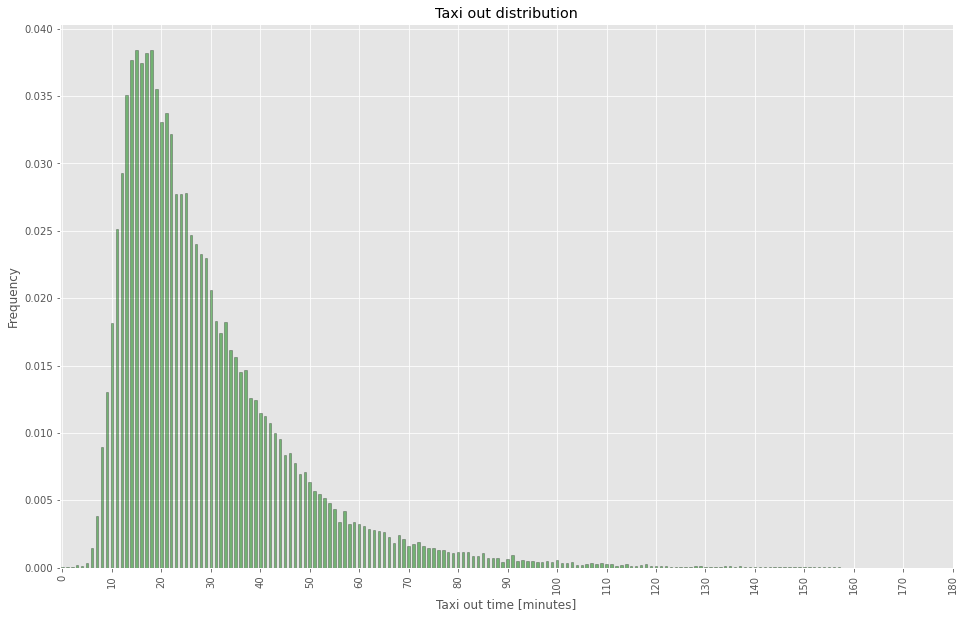

In [15]:
# Plot taxi out time
df_tax = df.groupby(["TAXI_OUT"]).size()
df_tax = df_tax / df_tax.sum()
df_tax.plot.bar(color='green', alpha=0.5, edgecolor='black')
plt.xticks(ticks = np.arange(0, 186, 10), labels = np.arange(0, 186, 10))
plt.title('Taxi out distribution')
plt.xlabel('Taxi out time [minutes]')
plt.ylabel('Frequency');

In the plot above we see the distribution of the variable taxi_out. The distribution looks like a gamma distribution, where most of the observations are in the interval 10-50 mins. However, the tail to the right shows that some flights have a long taxi_out time. This could have influence on the departure delay for the flights. 

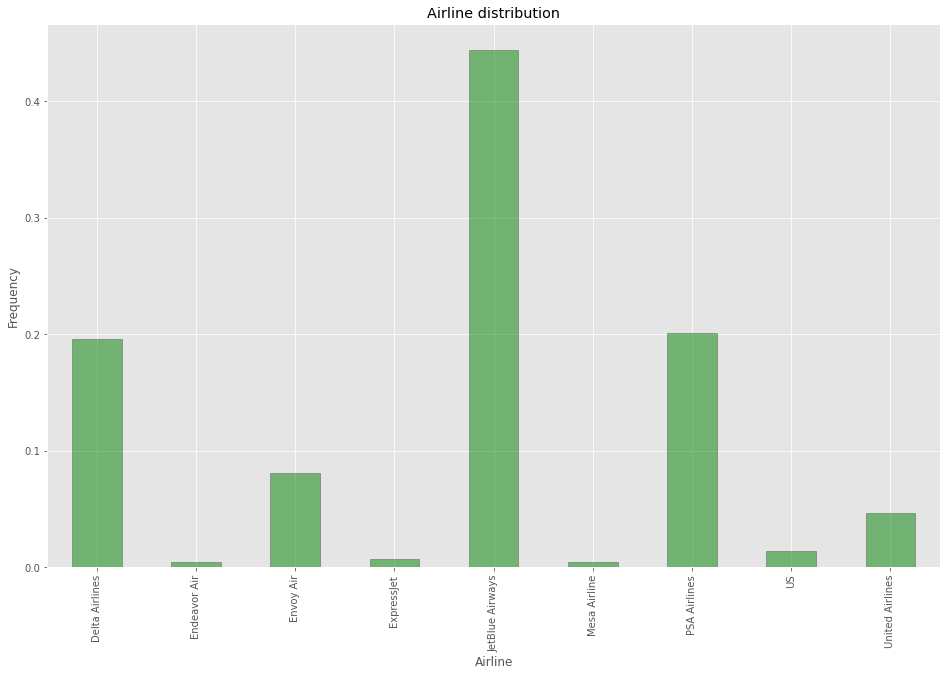

In [16]:
# Get all operators
df_ops = df.filter(regex='OP_CARRIER')
df_ops = df_ops.sum()[1:]

# Get labels
labs = []
lst_idx = list(df_ops.index)
for i in range(len(lst_idx)):
    labs.append(lst_idx[i].replace('OP_CARRIER_', ''))

# Set labels as index
df_ops = df_ops.set_axis(labs)
df_ops = df_ops / sum(df_ops)
df_ops.plot.bar(color='green', alpha=0.5, edgecolor='black')
plt.title('Airline distribution')
plt.xlabel('Airline')
plt.ylabel('Frequency');

The plot above shows the distribution of the different airlines. We see that JetBlue Airways, PSA Airlines and Delta Airlines are the most used airlines in the first six months of 2010. 

/var/folders/fs/10_w6dn131d7nmw8myr18l6r0000gn/T/ipykernel_63407/3524209277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delays['DEP_TIME'] = pd.to_datetime(delays.DEP_TIME, format="%H:%M:%S").dt.hour


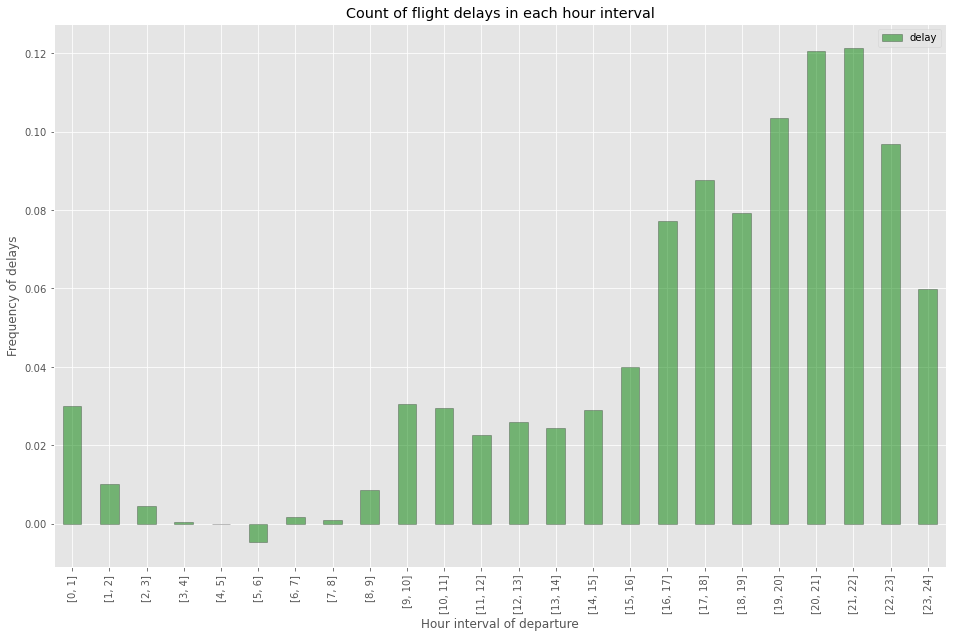

In [17]:
delays = df[['DEP_DELAY', 'DEP_TIME']]
delays['DEP_TIME'] = pd.to_datetime(delays.DEP_TIME, format="%H:%M:%S").dt.hour

# Group by delays
labels = ["[0, 1]", "[1, 2]", "[2, 3]", "[3, 4]", "[4, 5]", "[5, 6]",  "[6, 7]", "[7, 8]", "[8, 9]", "[9, 10]", "[10, 11]", "[11, 12]", "[12, 13]", "[13, 14]", "[14, 15]", "[15, 16]", "[16, 17]", "[17, 18]", "[18, 19]", "[19, 20]", "[20, 21]", "[21, 22]", "[22, 23]", "[23, 24]"] # labels
bins= np.arange(0,25) # intervals
X_dep = delays.copy() # Copy data frame
X_cut = pd.cut(delays['DEP_TIME'], bins=bins, labels=labels, right=False) # cut dataframe
X_dep['dep_group'] = X_cut # Add departure_group

# Create new data frame
cols = ['delay']
df_dep = pd.DataFrame(index=labels, columns=cols)

# take values
values = X_dep.groupby(['dep_group', 'DEP_DELAY']).size()

# Loop
for idx, t in enumerate(labels):
    # Assign total number of delays
    df_dep.delay[idx] = X_dep[X_dep.dep_group == t]['DEP_DELAY'].sum()
    

# Add column and reset index
df_dep['dep_group'] = labels
df_dep = df_dep.reset_index().drop('index', axis=1)

# Plot the data frame in each group
df_dep.set_index('dep_group', inplace=True)
df_dep = df_dep / sum(df_dep.delay)
ax = df_dep.plot.bar(color='green', alpha=0.5, edgecolor='black')
ax.set_xlabel('Hour interval of departure')
ax.set_ylabel('Frequency of delays')
ax.set_title('Count of flight delays in each hour interval');

The plot above shows the flight delays in each hour interval. In the plot we see that few flights are delayed during the night and most of the flights are delayed in during the afternoon and evening. 

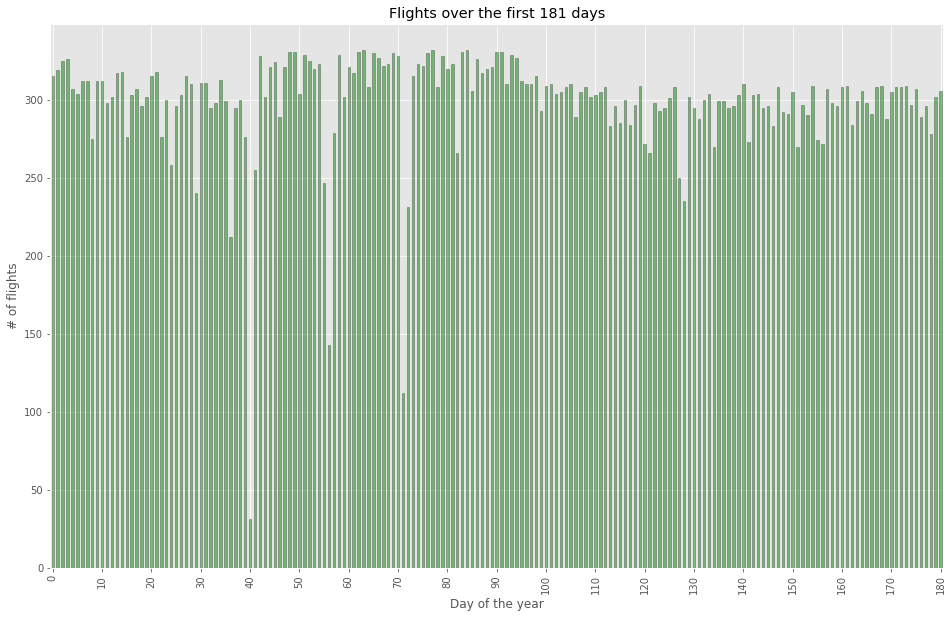

In [18]:
# Plot number of flights for the first six months of 2010
df_date = df.groupby(["FL_DATE"]).size() 
df_date.plot.bar(color='green', alpha=0.5, edgecolor='black')
plt.xticks(ticks = np.arange(0, 181, 10), labels = np.arange(0, 181, 10))
plt.title('Flights over the first 181 days')
plt.xlabel('Day of the year')
plt.ylabel('# of flights');

In the plot above we see how the number of flights are distributed during the time period of the dataset. Overall the distribution is uniform, but there are a few days with a drop in the number of flights. 

## Model building

We are now going to build models with the objective of predicting flight delays. First we construuct a linear model which is our baseline model. Then we create a Bayesian Neural Network.

#### Linear Regression Model

In [19]:
########## Load data
# Read preprocessed data
df = pd.read_csv("Data/data_pre.csv")
df = df.dropna()

Select the kind of data frame you want for the different models, by uncommenting the one you want below. Choose between

1. Standard $\textbf{x}_f$ parameters
2. Include average of delays from previous day
3. Include standard deviation of delays from previous day 
4. Include average and standard deviation of delays from previous day 

In [20]:
# Standard, non-time-series (uncomment to run this)
df = df.drop(columns=['Unnamed: 0', 'DELAY_PREV_STD', 'DELAY_PREV_AVG'])

# Only Average (uncomment to run this)
#df = df.drop(columns=['Unnamed: 0', 'DELAY_PREV_STD'])

# Only STD (uncomment to run this)
#df = df.drop(columns=['Unnamed: 0', 'DELAY_PREV_AVG'])

# Both (uncomment to run this)
#df = df.drop(columns=['Unnamed: 0'])

Define features in X matrix and delays in target variabel y

In [21]:
y = df.DEP_DELAY
dates = df.FL_DATE
X = df.drop(["DEP_DELAY"],axis=1)
X["FL_DATE"] = pd.to_datetime(X["FL_DATE"]).dt.dayofyear
# Convert DEP_TIME to integer hour
X["DEP_TIME"] = pd.to_datetime(X["DEP_TIME"]).dt.hour

Split the data into train and test set. We set the test size to be 33% of all data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Define error measures in a function, *compute_error*

In [23]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

Define baseline model in PYRO: predictions are sampled from a normal distribution with mean of linear regression.

In [24]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [25]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train.to_numpy()[:1000,:]).float()
y_train_small = torch.tensor(y_train.to_numpy()[:1000]).float()

In [26]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()


Sample: 100%|██████████| 1200/1200 [02:29,  8.01it/s, step size=8.10e-02, acc. prob=0.923]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.21      0.97      0.22     -1.38      1.73   1387.37      1.00
   beta[0]      0.03      0.07      0.03     -0.09      0.14    542.62      1.00
   beta[1]      1.27      0.23      1.27      0.87      1.64   1651.44      1.00
   beta[2]      0.23      0.06      0.23      0.14      0.33   1499.78      1.00
   beta[3]     -0.08      0.23     -0.08     -0.46      0.32    528.66      1.00
   beta[4]     -1.02      0.47     -1.04     -1.82     -0.29    496.92      1.00
   beta[5]      0.57      0.92      0.58     -0.86      2.08   1350.81      1.00
   beta[6]      0.48      0.94      0.46     -1.08      2.01   1374.20      1.00
   beta[7]     -0.01      1.06     -0.00     -1.69      1.70   1753.42      1.00
   beta[8]     -0.39      0.99     -0.43     -1.84      1.31   1183.39      1.00
   beta[9]     -0.03      1.02     -0.01     -1.60      1.67   1320.84      1.00
  beta[10]      0.32      0

Display results by printing error measure and show predictions for the first 100 observations in test data

CorrCoef: 0.273
MAE: 20.298
RMSE: 36.617
R2: 0.069


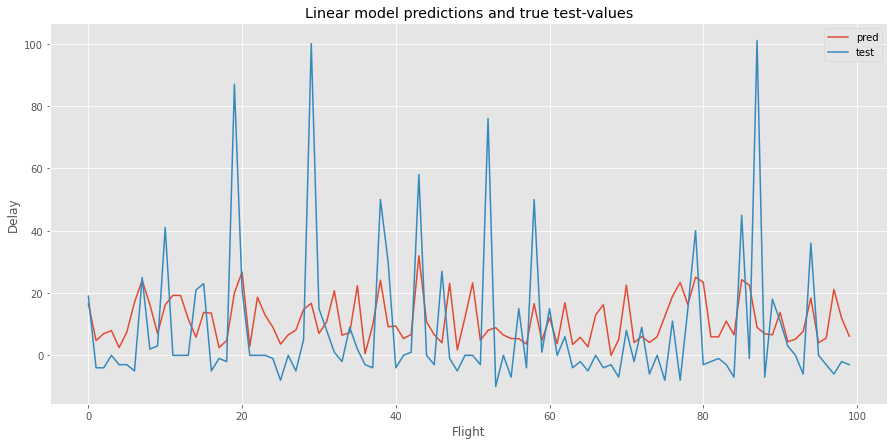

In [27]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
preds = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test.to_numpy(), posterior_samples["beta"].numpy().T), axis=1)
# Define true values
y_true = y_test

# Compute errors
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

y_true = y_true.reset_index().drop('index',axis=1)
fig = plt.subplots(1,figsize=(15,7))
plt.plot(preds[:100],label='pred')
plt.plot(y_true[:100],label='test')
plt.title('Linear model predictions and true test-values')
plt.xlabel('Flight')
plt.ylabel('Delay')
plt.legend()

#### Neural Network model

In [28]:
###### Define feature matrix and target variable
y = df.DEP_DELAY
dates = df.FL_DATE
X = df.drop(["DEP_DELAY"],axis=1)
X["FL_DATE"] = pd.to_datetime(X["FL_DATE"]).dt.dayofyear
# Convert DEP_TIME to integer hour
X["DEP_TIME"] = pd.to_datetime(X["DEP_TIME"]).dt.hour

In [29]:
# Make split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
# Convert to torch tensor object
Xnn = torch.tensor(X.to_numpy()).float()
ynn = torch.tensor(y.to_numpy()).float()

Below we define the structure of the neural network. We have experimented with different number of hidden layers and units in each layer. The structure with the best predictions are 3 hidden layers with 32, 64 and 32 units respectively.

In [31]:
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_hidden2, n_hidden3, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden2)
        self.h_layer2 = torch.nn.Linear(n_hidden2, n_hidden3)
        self.h_layer3 = torch.nn.Linear(n_hidden3, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.sig = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(p=0.3)
        
    def forward(self, X):
        # Forward pass
        X = self.sig(self.in_layer(X))
        X = self.sig(self.h_layer(X))
        X = self.sig(self.h_layer2(X))
        X = self.sig(self.h_layer3(X))
        X = self.out_layer(X)
        
        return X

In [32]:
def nnet_model(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1], n_hidden=32, n_hidden2=64, n_hidden3=32, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # The generative process
    with pyro.plate("observations"):
        prediction_mean = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
        
    return y

In [33]:
# Define guide function
guide = AutoDiagonalNormal(nnet_model)

# Reset parameter values
pyro.clear_param_store()

We have also experimented with different settings in the optimizer. We have experimented with weight_decay in the *adam_params* variable and different values of learning rate. However, we obtained the best predictions with *adam_params* containging only a learning rate with the value of 0.01.

In [34]:
# Define the number of optimization steps
n_steps = 12000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(Xnn, ynn)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/Users/frederikhartmann/opt/anaconda3/lib/python3.9/site-packages/pyro/primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


[0] ELBO: 4471666151.1
[500] ELBO: 3547890167.0
[1000] ELBO: 3265191989.2
[1500] ELBO: 2998216258.3
[2000] ELBO: 2901789035.2
[2500] ELBO: 2815004711.6
[3000] ELBO: 2762307417.6
[3500] ELBO: 2750326595.7
[4000] ELBO: 2733581181.7
[4500] ELBO: 2648659629.0
[5000] ELBO: 2620358312.3
[5500] ELBO: 2586497965.4
[6000] ELBO: 2550475723.4
[6500] ELBO: 2518991420.6
[7000] ELBO: 2474324014.2
[7500] ELBO: 2431766501.4
[8000] ELBO: 2381928405.9
[8500] ELBO: 2386367771.0
[9000] ELBO: 2352979104.5
[9500] ELBO: 2336267392.9
[10000] ELBO: 2308020918.5
[10500] ELBO: 2274252280.1
[11000] ELBO: 2271384125.7
[11500] ELBO: 2250066735.2


In [35]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test.to_numpy()).float()

In [36]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(nnet_model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

Display results by printing error measures and display the first 100 predictions on test data.

CorrCoef: 0.645
MAE: 16.451
RMSE: 28.988
R2: 0.416


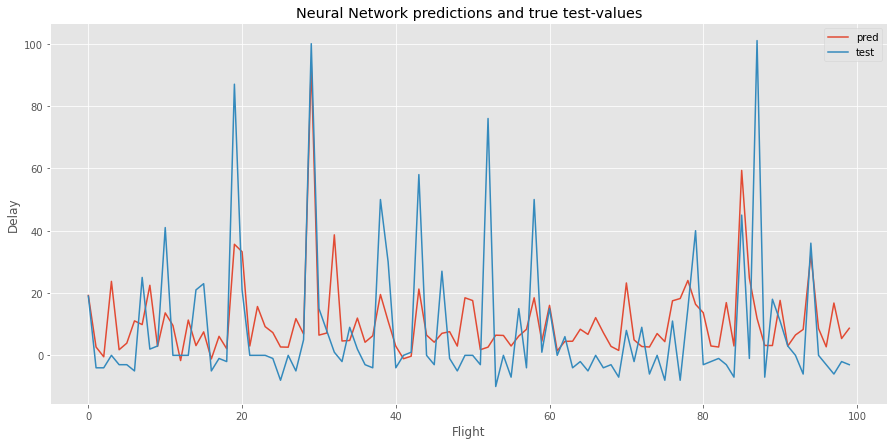

In [37]:
y_pred = samples["obs"].mean(axis=0).detach().numpy()

corr, mae, rae, rmse, r2 = compute_error(y_test, y_pred)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

# Save results in new variables
y_t = y_test
y_p = y_pred

# Drop index
y_t = y_t.reset_index().drop('index',axis=1)

# Plot
fig = plt.subplots(1,figsize=(15,7))
plt.plot(y_p[:100],label='pred')
plt.plot(y_t[:100],label='test')
plt.title('Neural Network predictions and true test-values')
plt.xlabel('Flight')
plt.ylabel('Delay')
plt.legend()

# Discussion

In this project, we have made multiple decisions to simplify the problems at hand and improve model performance. First, the weather data we found did not contain information regarding rain and/or snow. Potentially, such information could impact flight delays quite significantly so we would argue it would be beneficial to include rain and snow features in future work. Another aspect where we could improve the project is in training the neural networks. We have tried tuning different hyper parameters for the neural networks but ultimately we would have liked to run a more extensive hyper-parameter search to find the best possible hyper parameters if time had allowed us to do so. Furthermore we would have liked to investigate if adding an error-term, that acts as a random walk for each day, would improve the model performance.